# Data cleaning

In [11]:
!pip install mlflow
!pip install --upgrade xlrd
!!pip install pyLDAvis
!pip3 install wordcloud

In [12]:
import numpy as np
import string
import pandas as pd
import seaborn as sns
import os
import re
import json
import mlflow
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import scipy
import gensim
import warnings
warnings.simplefilter('ignore')
from itertools import chain

In [13]:
def load_data():
    pd.set_option('display.max_colwidth', 100)
    df = pd.read_excel("esg-corpus.xls")
    df.columns = ['ID','Company','Text']
    return df

In [14]:
df = load_data()

<AxesSubplot:>

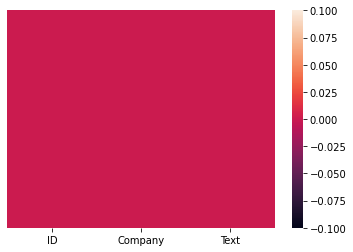

In [15]:
sns.heatmap(df.isnull(), yticklabels=False)

In [16]:
def remove_punctuation(txt):
    txt_nopunct = "".join([c for c in txt if c not in string.punctuation])
    return txt_nopunct

df['esg_clean'] = df['Text'].apply(lambda x: remove_punctuation(x))
df.head()

,ID,Company,Text,esg_clean
0,1,Enbridge,"Bridge to the future 2020 Sustainability Report At Enbridge, we deliver the energy that fuels pe...",Bridge to the future 2020 Sustainability Report At Enbridge we deliver the energy that fuels peo...
1,1,Enbridge,Our approach Healthier planet Safe operations Inclusive society Energized workforce Responsible...,Our approach Healthier planet Safe operations Inclusive society Energized workforce Responsible...
2,1,Enbridge,Our approach Healthier planet Safe operations Inclusive society Energized workforce Responsible...,Our approach Healthier planet Safe operations Inclusive society Energized workforce Responsible...
3,1,Enbridge,Our approach Healthier planet Safe operations Inclusive society Energized workforce Responsible...,Our approach Healthier planet Safe operations Inclusive society Energized workforce Responsible...
4,1,Enbridge,Our approach Healthier planet Safe operations Inclusive society Energized workforce Responsible...,Our approach Healthier planet Safe operations Inclusive society Energized workforce Responsible...


In [17]:
def tokenize(txt):
    tokens = re.split('\W+', txt)
    return tokens

df['esg_clean_tokenized'] = df['esg_clean'].apply(lambda x: tokenize(x.lower()))

df.head()

,ID,Company,Text,esg_clean,esg_clean_tokenized
0,1,Enbridge,"Bridge to the future 2020 Sustainability Report At Enbridge, we deliver the energy that fuels pe...",Bridge to the future 2020 Sustainability Report At Enbridge we deliver the energy that fuels peo...,"[bridge, to, the, future, 2020, sustainability, report, at, enbridge, we, deliver, the, energy, ..."
1,1,Enbridge,Our approach Healthier planet Safe operations Inclusive society Energized workforce Responsible...,Our approach Healthier planet Safe operations Inclusive society Energized workforce Responsible...,"[, our, approach, healthier, planet, safe, operations, inclusive, society, energized, workforce,..."
2,1,Enbridge,Our approach Healthier planet Safe operations Inclusive society Energized workforce Responsible...,Our approach Healthier planet Safe operations Inclusive society Energized workforce Responsible...,"[, our, approach, healthier, planet, safe, operations, inclusive, society, energized, workforce,..."
3,1,Enbridge,Our approach Healthier planet Safe operations Inclusive society Energized workforce Responsible...,Our approach Healthier planet Safe operations Inclusive society Energized workforce Responsible...,"[, our, approach, healthier, planet, safe, operations, inclusive, society, energized, workforce,..."
4,1,Enbridge,Our approach Healthier planet Safe operations Inclusive society Energized workforce Responsible...,Our approach Healthier planet Safe operations Inclusive society Energized workforce Responsible...,"[, our, approach, healthier, planet, safe, operations, inclusive, society, energized, workforce,..."


In [18]:
import nltk
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rohaanzuberi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
# context specific keywords not to be included in the topic modeling stage

new_stopwords = ["report", "annual", "2021", "2020", "2019", "2018", "corp", "enbridge", "nextera", "altagas", "tidewater", "midstream", "veresen", "husky", "suncor", "imperial", "canadian", "canada", "cenovus", "enerplus", "syncrude", "surge", "pipestone", "arc", "tc", "pembina", "keyera", "tamarack", "valley", "aecom", "bc", "ameresco", "basf", "algonquin", "repsol", "paramount", "meg", "peyto", "advantage", "birchcliff", "baytex", "crescent", "point", "generations", "seven", "whitecap", "teck", "tourmaline", "vermilion", "nuvista", "westbrick", "mancal", "pinecliff", "cardinal", "conocophillips", "invenergy", "northland", "plc", "group", "track", "holding", "annual", "long", "make", "est", "!", "@", "#", "$", "%", "^", "*", "(", ")", ".", "meant", "name", "convey", "äì", "äü", "úì", "also", "0", "1", "äù", "2", "3", "4", "5", "6", "7", "8", "9", "10"]
stpwrd = nltk.corpus.stopwords.words('english')
combined_stopwords = stpwrd.extend(new_stopwords)

In [20]:
def remove_stpwrd(txt_tokenized):
    txt_clean = [word for word in txt_tokenized if word not in stpwrd]
    return txt_clean

df['esg_no_stpw'] = df['esg_clean_tokenized'].apply(lambda x: remove_stpwrd(x))
df.head()

,ID,Company,Text,esg_clean,esg_clean_tokenized,esg_no_stpw
0,1,Enbridge,"Bridge to the future 2020 Sustainability Report At Enbridge, we deliver the energy that fuels pe...",Bridge to the future 2020 Sustainability Report At Enbridge we deliver the energy that fuels peo...,"[bridge, to, the, future, 2020, sustainability, report, at, enbridge, we, deliver, the, energy, ...","[bridge, future, sustainability, deliver, energy, fuels, people, quality, life, commitment, brid..."
1,1,Enbridge,Our approach Healthier planet Safe operations Inclusive society Energized workforce Responsible...,Our approach Healthier planet Safe operations Inclusive society Energized workforce Responsible...,"[, our, approach, healthier, planet, safe, operations, inclusive, society, energized, workforce,...","[, approach, healthier, planet, safe, operations, inclusive, society, energized, workforce, resp..."
2,1,Enbridge,Our approach Healthier planet Safe operations Inclusive society Energized workforce Responsible...,Our approach Healthier planet Safe operations Inclusive society Energized workforce Responsible...,"[, our, approach, healthier, planet, safe, operations, inclusive, society, energized, workforce,...","[, approach, healthier, planet, safe, operations, inclusive, society, energized, workforce, resp..."
3,1,Enbridge,Our approach Healthier planet Safe operations Inclusive society Energized workforce Responsible...,Our approach Healthier planet Safe operations Inclusive society Energized workforce Responsible...,"[, our, approach, healthier, planet, safe, operations, inclusive, society, energized, workforce,...","[, approach, healthier, planet, safe, operations, inclusive, society, energized, workforce, resp..."
4,1,Enbridge,Our approach Healthier planet Safe operations Inclusive society Energized workforce Responsible...,Our approach Healthier planet Safe operations Inclusive society Energized workforce Responsible...,"[, our, approach, healthier, planet, safe, operations, inclusive, society, energized, workforce,...","[, approach, healthier, planet, safe, operations, inclusive, society, energized, workforce, resp..."


In [21]:
import nltk
from nltk.stem import PorterStemmer
ps = PorterStemmer()

In [22]:
def stemming(tokenized_text):
    text = [ps.stem(word) for word in tokenized_text]
    return text

In [23]:
df ['esg_stemmed'] = df['esg_no_stpw'].apply(lambda x: stemming(x))
df.head()

,ID,Company,Text,esg_clean,esg_clean_tokenized,esg_no_stpw,esg_stemmed
0,1,Enbridge,"Bridge to the future 2020 Sustainability Report At Enbridge, we deliver the energy that fuels pe...",Bridge to the future 2020 Sustainability Report At Enbridge we deliver the energy that fuels peo...,"[bridge, to, the, future, 2020, sustainability, report, at, enbridge, we, deliver, the, energy, ...","[bridge, future, sustainability, deliver, energy, fuels, people, quality, life, commitment, brid...","[bridg, futur, sustain, deliv, energi, fuel, peopl, qualiti, life, commit, bridg, safer, cleaner..."
1,1,Enbridge,Our approach Healthier planet Safe operations Inclusive society Energized workforce Responsible...,Our approach Healthier planet Safe operations Inclusive society Energized workforce Responsible...,"[, our, approach, healthier, planet, safe, operations, inclusive, society, energized, workforce,...","[, approach, healthier, planet, safe, operations, inclusive, society, energized, workforce, resp...","[, approach, healthier, planet, safe, oper, inclus, societi, energ, workforc, respons, busi, sus..."
2,1,Enbridge,Our approach Healthier planet Safe operations Inclusive society Energized workforce Responsible...,Our approach Healthier planet Safe operations Inclusive society Energized workforce Responsible...,"[, our, approach, healthier, planet, safe, operations, inclusive, society, energized, workforce,...","[, approach, healthier, planet, safe, operations, inclusive, society, energized, workforce, resp...","[, approach, healthier, planet, safe, oper, inclus, societi, energ, workforc, respons, busi, sus..."
3,1,Enbridge,Our approach Healthier planet Safe operations Inclusive society Energized workforce Responsible...,Our approach Healthier planet Safe operations Inclusive society Energized workforce Responsible...,"[, our, approach, healthier, planet, safe, operations, inclusive, society, energized, workforce,...","[, approach, healthier, planet, safe, operations, inclusive, society, energized, workforce, resp...","[, approach, healthier, planet, safe, oper, inclus, societi, energ, workforc, respons, busi, sus..."
4,1,Enbridge,Our approach Healthier planet Safe operations Inclusive society Energized workforce Responsible...,Our approach Healthier planet Safe operations Inclusive society Energized workforce Responsible...,"[, our, approach, healthier, planet, safe, operations, inclusive, society, energized, workforce,...","[, approach, healthier, planet, safe, operations, inclusive, society, energized, workforce, resp...","[, approach, healthier, planet, safe, oper, inclus, societi, energ, workforc, respons, busi, sus..."


In [24]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
wn = nltk.WordNetLemmatizer()
ps = nltk.PorterStemmer()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/rohaanzuberi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/rohaanzuberi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [25]:
def lemmatization(token_text):
    text = [wn.lemmatize(word) for word in token_text]
    return text

In [26]:
df['esg_lemmatized'] = df['esg_no_stpw'].apply(lambda x: lemmatization(x))
df.head()

,ID,Company,Text,esg_clean,esg_clean_tokenized,esg_no_stpw,esg_stemmed,esg_lemmatized
0,1,Enbridge,"Bridge to the future 2020 Sustainability Report At Enbridge, we deliver the energy that fuels pe...",Bridge to the future 2020 Sustainability Report At Enbridge we deliver the energy that fuels peo...,"[bridge, to, the, future, 2020, sustainability, report, at, enbridge, we, deliver, the, energy, ...","[bridge, future, sustainability, deliver, energy, fuels, people, quality, life, commitment, brid...","[bridg, futur, sustain, deliv, energi, fuel, peopl, qualiti, life, commit, bridg, safer, cleaner...","[bridge, future, sustainability, deliver, energy, fuel, people, quality, life, commitment, bridg..."
1,1,Enbridge,Our approach Healthier planet Safe operations Inclusive society Energized workforce Responsible...,Our approach Healthier planet Safe operations Inclusive society Energized workforce Responsible...,"[, our, approach, healthier, planet, safe, operations, inclusive, society, energized, workforce,...","[, approach, healthier, planet, safe, operations, inclusive, society, energized, workforce, resp...","[, approach, healthier, planet, safe, oper, inclus, societi, energ, workforc, respons, busi, sus...","[, approach, healthier, planet, safe, operation, inclusive, society, energized, workforce, respo..."
2,1,Enbridge,Our approach Healthier planet Safe operations Inclusive society Energized workforce Responsible...,Our approach Healthier planet Safe operations Inclusive society Energized workforce Responsible...,"[, our, approach, healthier, planet, safe, operations, inclusive, society, energized, workforce,...","[, approach, healthier, planet, safe, operations, inclusive, society, energized, workforce, resp...","[, approach, healthier, planet, safe, oper, inclus, societi, energ, workforc, respons, busi, sus...","[, approach, healthier, planet, safe, operation, inclusive, society, energized, workforce, respo..."
3,1,Enbridge,Our approach Healthier planet Safe operations Inclusive society Energized workforce Responsible...,Our approach Healthier planet Safe operations Inclusive society Energized workforce Responsible...,"[, our, approach, healthier, planet, safe, operations, inclusive, society, energized, workforce,...","[, approach, healthier, planet, safe, operations, inclusive, society, energized, workforce, resp...","[, approach, healthier, planet, safe, oper, inclus, societi, energ, workforc, respons, busi, sus...","[, approach, healthier, planet, safe, operation, inclusive, society, energized, workforce, respo..."
4,1,Enbridge,Our approach Healthier planet Safe operations Inclusive society Energized workforce Responsible...,Our approach Healthier planet Safe operations Inclusive society Energized workforce Responsible...,"[, our, approach, healthier, planet, safe, operations, inclusive, society, energized, workforce,...","[, approach, healthier, planet, safe, operations, inclusive, society, energized, workforce, resp...","[, approach, healthier, planet, safe, oper, inclus, societi, energ, workforc, respons, busi, sus...","[, approach, healthier, planet, safe, operation, inclusive, society, energized, workforce, respo..."


In [27]:
data_words = df['esg_lemmatized']
print(data_words)

0       [bridge, future, sustainability, deliver, energy, fuel, people, quality, life, commitment, bridg...
1       [, approach, healthier, planet, safe, operation, inclusive, society, energized, workforce, respo...
2       [, approach, healthier, planet, safe, operation, inclusive, society, energized, workforce, respo...
3       [, approach, healthier, planet, safe, operation, inclusive, society, energized, workforce, respo...
4       [, approach, healthier, planet, safe, operation, inclusive, society, energized, workforce, respo...
                                                       ...                                                 
1386    [, sustainability, power, inc, 25, community, saskatchewan, food, bank, donation, power, energ, ...
1387    [, business, priority, focus, responsible, corporate, governance, information, security, board, ...
1388    [, 28, power, inc, power, connection, identifying, managing, risk, accountable, ethical, transpa...
1389    [, 30, power, inc, p

In [28]:
df.to_csv("esg_new1.csv")

# Step 3: Topic Modeling

In [29]:
# aggregate all text data into one large string to run wordcloud on term frequency

large_string = df.to_string(columns=["esg_lemmatized"], header=False, index=False, index_names=False)
print(large_string)

                                                                                                                                                                                                                                                                                                                                                                                                    [bridge, future, sustainability, deliver, energy, fuel, people, quality, life, commitment, bridge, safer, cleaner, affordable, energy, future, u, building, bridge, equitable, inclusive, sustainable, future, stakeholder, inc, leading, north, american, energy, infrastructure, company, safely, reliably, deliver, energy, people, need, want, fuel, quality, life, core, business, include, liquid, pipeline, lp, transport, approximately, 25, crude, oil, produced, north, america, gas, transmission, gtm, transport, approximately, 20, natural, gas, consumed, u, gas, distribution, storage, gd, serf, approximately, 38,

In [30]:
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

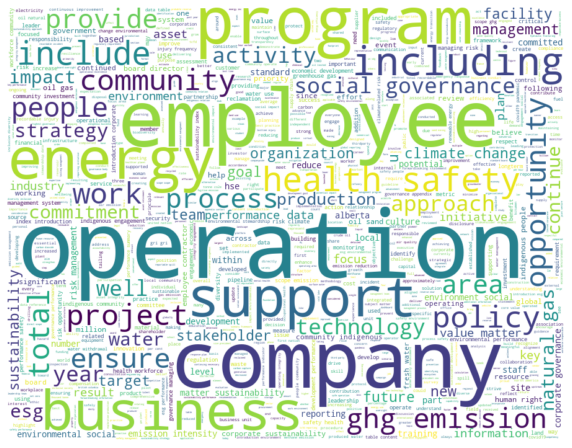

In [31]:
word_cloud = WordCloud(
    background_color="white",
    max_words=5000, 
    width=900, 
    height=700, 
    stopwords=stpwrd, 
    contour_width=3, 
    contour_color='steelblue'
)


# display the wordcloud for all data

plt.figure(figsize=(10,10))
word_cloud.generate(large_string)
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

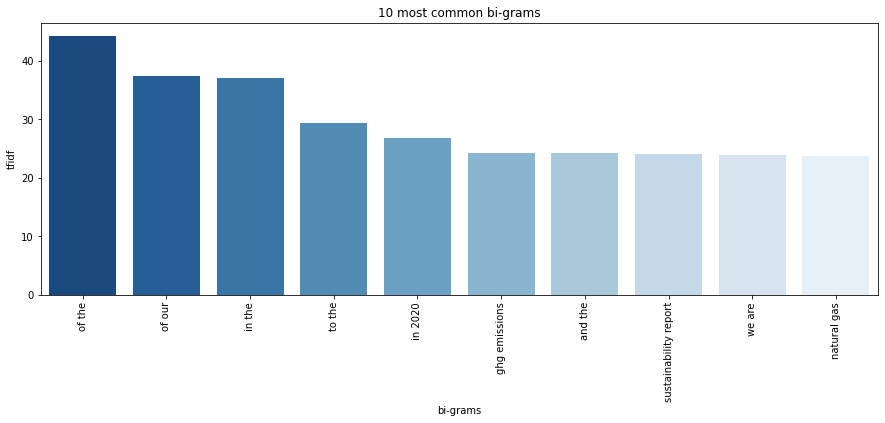

In [64]:
# Run bi-gram TF-IDF frequencies
bigram_tf_idf_vectorizer = TfidfVectorizer(stop_words=combined_stopwords, ngram_range=(2,2), min_df=10, use_idf=True)
bigram_tf_idf = bigram_tf_idf_vectorizer.fit_transform(df['esg_clean'])

# Extract bi-grams names
words = bigram_tf_idf_vectorizer.get_feature_names()

# extract our top 10 ngrams
total_counts = np.zeros(len(words))
for t in bigram_tf_idf:
    total_counts += t.toarray()[0]

count_dict = (zip(words, total_counts))
count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
words = [w[0] for w in count_dict]
counts = [w[1] for w in count_dict]
x_pos = np.arange(len(words)) 

# Plot top 10 ngrams
plt.figure(figsize=(15, 5))
plt.subplot(title='10 most common bi-grams')
sns.barplot(x_pos, counts, palette='Blues_r')
plt.xticks(x_pos, words, rotation=90) 
plt.xlabel('bi-grams')
plt.ylabel('tfidf')
plt.show()

In [34]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_words)
# Create Corpus
texts = data_words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 2), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1)]


In [35]:
from pprint import pprint
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.011*"emission" + 0.006*"community" + 0.006*"energy" + 0.006*"safety" + '
  '0.006*"water" + 0.005*"sustainability" + 0.005*"performance" + '
  '0.005*"management" + 0.005*"business" + 0.005*"operation"'),
 (1,
  '0.009*"energy" + 0.007*"emission" + 0.007*"management" + 0.007*"community" '
  '+ 0.006*"water" + 0.006*"safety" + 0.005*"performance" + '
  '0.005*"environmental" + 0.005*"gas" + 0.005*"sustainability"'),
 (2,
  '0.008*"community" + 0.007*"employee" + 0.006*"management" + 0.006*"safety" '
  '+ 0.005*"energy" + 0.005*"business" + 0.005*"sustainability" + 0.004*"risk" '
  '+ 0.004*"performance" + 0.004*"health"'),
 (3,
  '0.007*"emission" + 0.007*"energy" + 0.006*"risk" + 0.006*"indigenous" + '
  '0.006*"community" + 0.006*"safety" + 0.006*"program" + 0.006*"business" + '
  '0.005*"gas" + 0.005*"management"'),
 (4,
  '0.007*"safety" + 0.007*"emission" + 0.006*"energy" + 0.006*"water" + '
  '0.006*"management" + 0.006*"operation" + 0.005*"community" + '
  '0.005*"progr

In [36]:
import pyLDAvis
import pyLDAvis.gensim_models
import pickle 
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/opt/anaconda3/envs/pythonProject1/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/pythonProject1/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/pythonProject1/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/envs/pythonProject1/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and 

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.005734 -0.008665       1        1  23.156961
5     -0.004544 -0.002940       2        1  14.762675
7      0.004777  0.004311       3        1  12.850788
0      0.001676 -0.002916       4        1  10.641365
2     -0.012371  0.005269       5        1   9.422376
4     -0.005342 -0.002619       6        1   8.522923
1      0.003382 -0.002980       7        1   7.502729
3     -0.006008 -0.002361       8        1   7.399972
8      0.004151  0.009682       9        1   3.419399
9      0.008544  0.003220      10        1   2.320811, topic_info=           Term         Freq        Total Category  logprob  loglift
89       energy  3804.000000  3804.000000  Default  30.0000  30.0000
197       water  3009.000000  3009.000000  Default  29.0000  29.0000
69    community  2786.000000  2786.000000  Default  28.0000  28.0000
457    employee  2872.000000  2872.000000  Default  27.0000  27.0000
130  management  2591.000000  2591.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
172      safety    36.136712  2931.867137  Topic10  -5.8273  -0.6328
148   operation    34.183418  2352.150559  Topic10  -5.8829  -0.4681
146         oil    32.125537  1833.102257  Topic10  -5.9450  -0.2809
92          esg    31.940077  1955.181853  Topic10  -5.9507  -0.3511
657        year    31.370174  1605.082699  Topic10  -5.9687  -0.1718

[834 rows x 6 columns], token_table=       Topic      Freq Term
term                       
2176       1  0.188366   00
2176       2  0.107638   00
2176       3  0.345979   00
2176       4  0.076884   00
2176       5  0.069196   00
...      ...       ...  ...
25681      3  0.103092   ùø
25681      4  0.103092   ùø
25681      5  0.103092   ùø
25681      6  0.103092   ùø
25681      7  0.206184   ùø

[2237 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 6, 8, 1, 3, 5, 2, 4, 9, 10])

In [37]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus,total_docs=10000))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
from gensim.models.coherencemodel import CoherenceModel
coherence_model_lda = CoherenceModel(model=lda_model, texts=df['esg_lemmatized'], dictionary=id2word , coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.038934689299408

Coherence Score:  0.355781179995163


In [38]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=df['esg_lemmatized'], dictionary=id2word, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [39]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=df['esg_lemmatized'], start=2, limit=50, step=1)

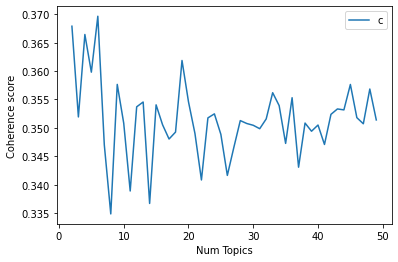

In [40]:
# Show graph
limit=50; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()# Print the coherence scores

In [41]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 48))

Num Topics = 2  has Coherence Value of 0.3678979120450503
Num Topics = 3  has Coherence Value of 0.3519278364528287
Num Topics = 4  has Coherence Value of 0.36644193704739525
Num Topics = 5  has Coherence Value of 0.35981159325600426
Num Topics = 6  has Coherence Value of 0.3696529497287549
Num Topics = 7  has Coherence Value of 0.3470244262985868
Num Topics = 8  has Coherence Value of 0.3348566468384105
Num Topics = 9  has Coherence Value of 0.357655170514832
Num Topics = 10  has Coherence Value of 0.35082542739498546
Num Topics = 11  has Coherence Value of 0.3388920241836128
Num Topics = 12  has Coherence Value of 0.3537065739544201
Num Topics = 13  has Coherence Value of 0.35455509690505865
Num Topics = 14  has Coherence Value of 0.33669961753845407
Num Topics = 15  has Coherence Value of 0.35405438696170916
Num Topics = 16  has Coherence Value of 0.3505450030062549
Num Topics = 17  has Coherence Value of 0.3480435255472868
Num Topics = 18  has Coherence Value of 0.3492603230204018


In [42]:
#create document term matrix
doc_term_matrix = [id2word.doc2bow(doc) for doc in df['esg_lemmatized'] ]
print(len(doc_term_matrix))

1391


In [43]:
# Assigns the topics to the documents in corpus
lda_corpus = lda_model[doc_term_matrix]

In [44]:
[doc for doc in lda_corpus]

[[(1, 0.01954642),
  (2, 0.5885829),
  (3, 0.022156203),
  (4, 0.0867956),
  (7, 0.27564806)],
 [(4, 0.014389241), (6, 0.80289), (7, 0.18040372)],
 [(2, 0.015372462), (4, 0.74358135), (6, 0.23396975)],
 [(0, 0.035396274),
  (2, 0.031819925),
  (3, 0.021341158),
  (4, 0.70676327),
  (6, 0.19887616)],
 [(2, 0.8033991), (3, 0.016938703), (4, 0.06372749), (7, 0.10820141)],
 [(6, 0.93731964), (7, 0.061284922)],
 [(0, 0.16042574), (3, 0.24821791), (6, 0.58651257)],
 [(0, 0.09897124),
  (1, 0.096960604),
  (4, 0.39769703),
  (6, 0.3734492),
  (7, 0.03208021)],
 [(1, 0.9649949), (6, 0.03163853)],
 [(1, 0.015748877), (4, 0.4407614), (6, 0.017560469), (7, 0.5249186)],
 [(5, 0.9937355)],
 [(0, 0.07995806),
  (3, 0.7019686),
  (4, 0.02768049),
  (5, 0.16778782),
  (6, 0.01208476)],
 [(0, 0.5983787), (2, 0.14910115), (3, 0.20870508), (4, 0.039824735)],
 [(0, 0.8548908), (2, 0.11742931), (3, 0.02630388)],
 [(1, 0.03575633), (2, 0.8162591), (3, 0.05861801), (4, 0.08864943)],
 [(2, 0.98606443), (4, 0.

In [45]:
scores = list(chain(*[[score for topic_id,score in topic] \
                      for topic in [doc for doc in lda_corpus]]))

threshold = sum(scores)/len(scores)
print(threshold)

0.38637289537450487


In [46]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=15))

[(0,
  '0.007*"energy" + 0.007*"safety" + 0.006*"emission" + 0.006*"water" + '
  '0.006*"performance" + 0.005*"gas" + 0.005*"employee" + 0.005*"community" + '
  '0.005*"management" + 0.005*"governance" + 0.005*"sustainability" + '
  '0.004*"year" + 0.004*"company" + 0.004*"oil" + 0.004*"value"'),
 (1,
  '0.008*"emission" + 0.006*"energy" + 0.006*"risk" + 0.006*"gas" + '
  '0.005*"performance" + 0.005*"employee" + 0.005*"safety" + 0.005*"operation" '
  '+ 0.004*"company" + 0.004*"indigenous" + 0.004*"community" + '
  '0.004*"program" + 0.004*"sustainability" + 0.004*"management" + '
  '0.004*"business"'),
 (2,
  '0.009*"employee" + 0.006*"emission" + 0.005*"safety" + 0.005*"business" + '
  '0.005*"management" + 0.005*"performance" + 0.005*"water" + 0.005*"risk" + '
  '0.005*"sustainability" + 0.004*"indigenous" + 0.004*"community" + '
  '0.004*"program" + 0.004*"esg" + 0.004*"energy" + 0.004*"operation"'),
 (3,
  '0.011*"emission" + 0.007*"energy" + 0.006*"safety" + 0.006*"operation" + 

In [47]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=df['esg_lemmatized']):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=df['esg_lemmatized'])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()


df_dominant_topic.columns = ['Company', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Company,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0,0.5590,"energy, safety, emission, water, performance, gas, employee, community, management, governance","[bridge, future, sustainability, deliver, energy, fuel, people, quality, life, commitment, bridg..."
1,1,4,0.7428,"energy, water, community, emission, management, sustainability, business, employee, operation, gas","[, approach, healthier, planet, safe, operation, inclusive, society, energized, workforce, respo..."
2,2,0,0.9473,"energy, safety, emission, water, performance, gas, employee, community, management, governance","[, approach, healthier, planet, safe, operation, inclusive, society, energized, workforce, respo..."
3,3,3,0.4063,"emission, energy, safety, operation, business, sustainability, water, community, performance, en...","[, approach, healthier, planet, safe, operation, inclusive, society, energized, workforce, respo..."
4,4,4,0.7601,"energy, water, community, emission, management, sustainability, business, employee, operation, gas","[, approach, healthier, planet, safe, operation, inclusive, society, energized, workforce, respo..."
5,5,4,0.8222,"energy, water, community, emission, management, sustainability, business, employee, operation, gas","[, approach, healthier, planet, safe, operation, inclusive, society, energized, workforce, respo..."
6,6,1,0.5579,"emission, energy, risk, gas, performance, employee, safety, operation, company, indigenous","[, approach, healthier, planet, safe, operation, inclusive, society, energized, workforce, respo..."
7,7,3,0.9030,"emission, energy, safety, operation, business, sustainability, water, community, performance, en...","[, approach, healthier, planet, safe, operation, inclusive, society, energized, workforce, respo..."
8,8,3,0.9966,"emission, energy, safety, operation, business, sustainability, water, community, performance, en...","[, approach, healthier, planet, safe, operation, inclusive, society, energized, workforce, respo..."
9,9,3,0.7004,"emission, energy, safety, operation, business, sustainability, water, community, performance, en...","[, approach, healthier, planet, safe, operation, inclusive, society, energized, workforce, respo..."


In [48]:
df_1 = df[['Company', 'Text', 'esg_lemmatized']]
df_2 = df_dominant_topic
df_2['Company'] = df_1['Company']
df_2['Text'] = df_1['Text']

topic_names = [
  'value employees',
  'strong governance', 
  'company transformation',
  'ethical investments',
  'sustainable finance'
]
new_df = df_2.replace({0.0:topic_names[0], 1.0: topic_names[1], 2.0:topic_names[2], 3.0:topic_names[3], 4.0:topic_names[4]}, regex=True)

new_df

,Company,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,Enbridge,value employees,0.5590,"energy, safety, emission, water, performance, gas, employee, community, management, governance","Bridge to the future 2020 Sustainability Report At Enbridge, we deliver the energy that fuels pe..."
1,Enbridge,sustainable finance,0.7428,"energy, water, community, emission, management, sustainability, business, employee, operation, gas",Our approach Healthier planet Safe operations Inclusive society Energized workforce Responsible...
2,Enbridge,value employees,0.9473,"energy, safety, emission, water, performance, gas, employee, community, management, governance",Our approach Healthier planet Safe operations Inclusive society Energized workforce Responsible...
3,Enbridge,ethical investments,0.4063,"emission, energy, safety, operation, business, sustainability, water, community, performance, en...",Our approach Healthier planet Safe operations Inclusive society Energized workforce Responsible...
4,Enbridge,sustainable finance,0.7601,"energy, water, community, emission, management, sustainability, business, employee, operation, gas",Our approach Healthier planet Safe operations Inclusive society Energized workforce Responsible...
...,...,...,...,...,...
1386,Northland Power,sustainable finance,0.9888,"energy, water, community, emission, management, sustainability, business, employee, operation, gas",Sustainability Report 2020 Northland Power Inc. 25 Our Community Saskatchewan Food bank donatio...
1387,Northland Power,value employees,0.4812,"energy, safety, emission, water, performance, gas, employee, community, management, governance",Our Business Priority focus: ‚ Responsible corporate governance ‚ Information security ‚ Board ...
1388,Northland Power,company transformation,0.9414,"employee, emission, safety, business, management, performance, water, risk, sustainability, indi...",28 Northland Power Inc. The Power of Connection Identifying and managing risks through accounta...
1389,Northland Power,sustainable finance,0.5810,"energy, water, community, emission, management, sustainability, business, employee, operation, gas",30 Northland Power Inc. The Power of Connection Materiality assessment Our approach This report...


In [49]:
df_ = new_df[['Company', 'Dominant_Topic', 'Text']]
df_.to_pickle('data.pkl')

In [50]:
df_dominant_topic.to_csv("esg_new2.csv")

In [51]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0,0.9992,"energy, safety, emission, water, performance, gas, employee, community, management, governance","[economic, economic, value, generated, 19, million, 3944, 4706, 4888, 3266, supplier, million, 1..."
1,1,0.9971,"emission, energy, risk, gas, performance, employee, safety, operation, company, indigenous","[performance, data, total, natural, gas, flared, 103m3, 2017, north, america, exploration, produ..."
2,2,0.9986,"employee, emission, safety, business, management, performance, water, risk, sustainability, indi...","[, material, topic, 2012, 2013, 2014, 2015, 2016, 2017, context, gri, parental, leave, parental,..."
3,3,0.9982,"emission, energy, safety, operation, business, sustainability, water, community, performance, en...","[ghg, emission, part, approach, managing, emission, focused, reducing, scope, scope, greenhouse,..."
4,4,0.9989,"energy, water, community, emission, management, sustainability, business, employee, operation, gas","[, overview, water, source, us, thermal, operation, require, water, input, steam, generation, se..."


In [52]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,0,"energy, safety, emission, water, performance, gas, employee, community, management, governance",311.0,0.2236
1,4,"energy, water, community, emission, management, sustainability, business, employee, operation, gas",99.0,0.0712
2,0,"energy, safety, emission, water, performance, gas, employee, community, management, governance",272.0,0.1955
3,3,"emission, energy, safety, operation, business, sustainability, water, community, performance, en...",220.0,0.1582
4,4,"energy, water, community, emission, management, sustainability, business, employee, operation, gas",489.0,0.3515
...,...,...,...,...
1386,4,"energy, water, community, emission, management, sustainability, business, employee, operation, gas",NaN,NaN
1387,0,"energy, safety, emission, water, performance, gas, employee, community, management, governance",NaN,NaN
1388,2,"employee, emission, safety, business, management, performance, water, risk, sustainability, indi...",NaN,NaN
1389,4,"energy, water, community, emission, management, sustainability, business, employee, operation, gas",NaN,NaN


In [53]:
df_dominant_topics.to_csv("esg_new2.csv")

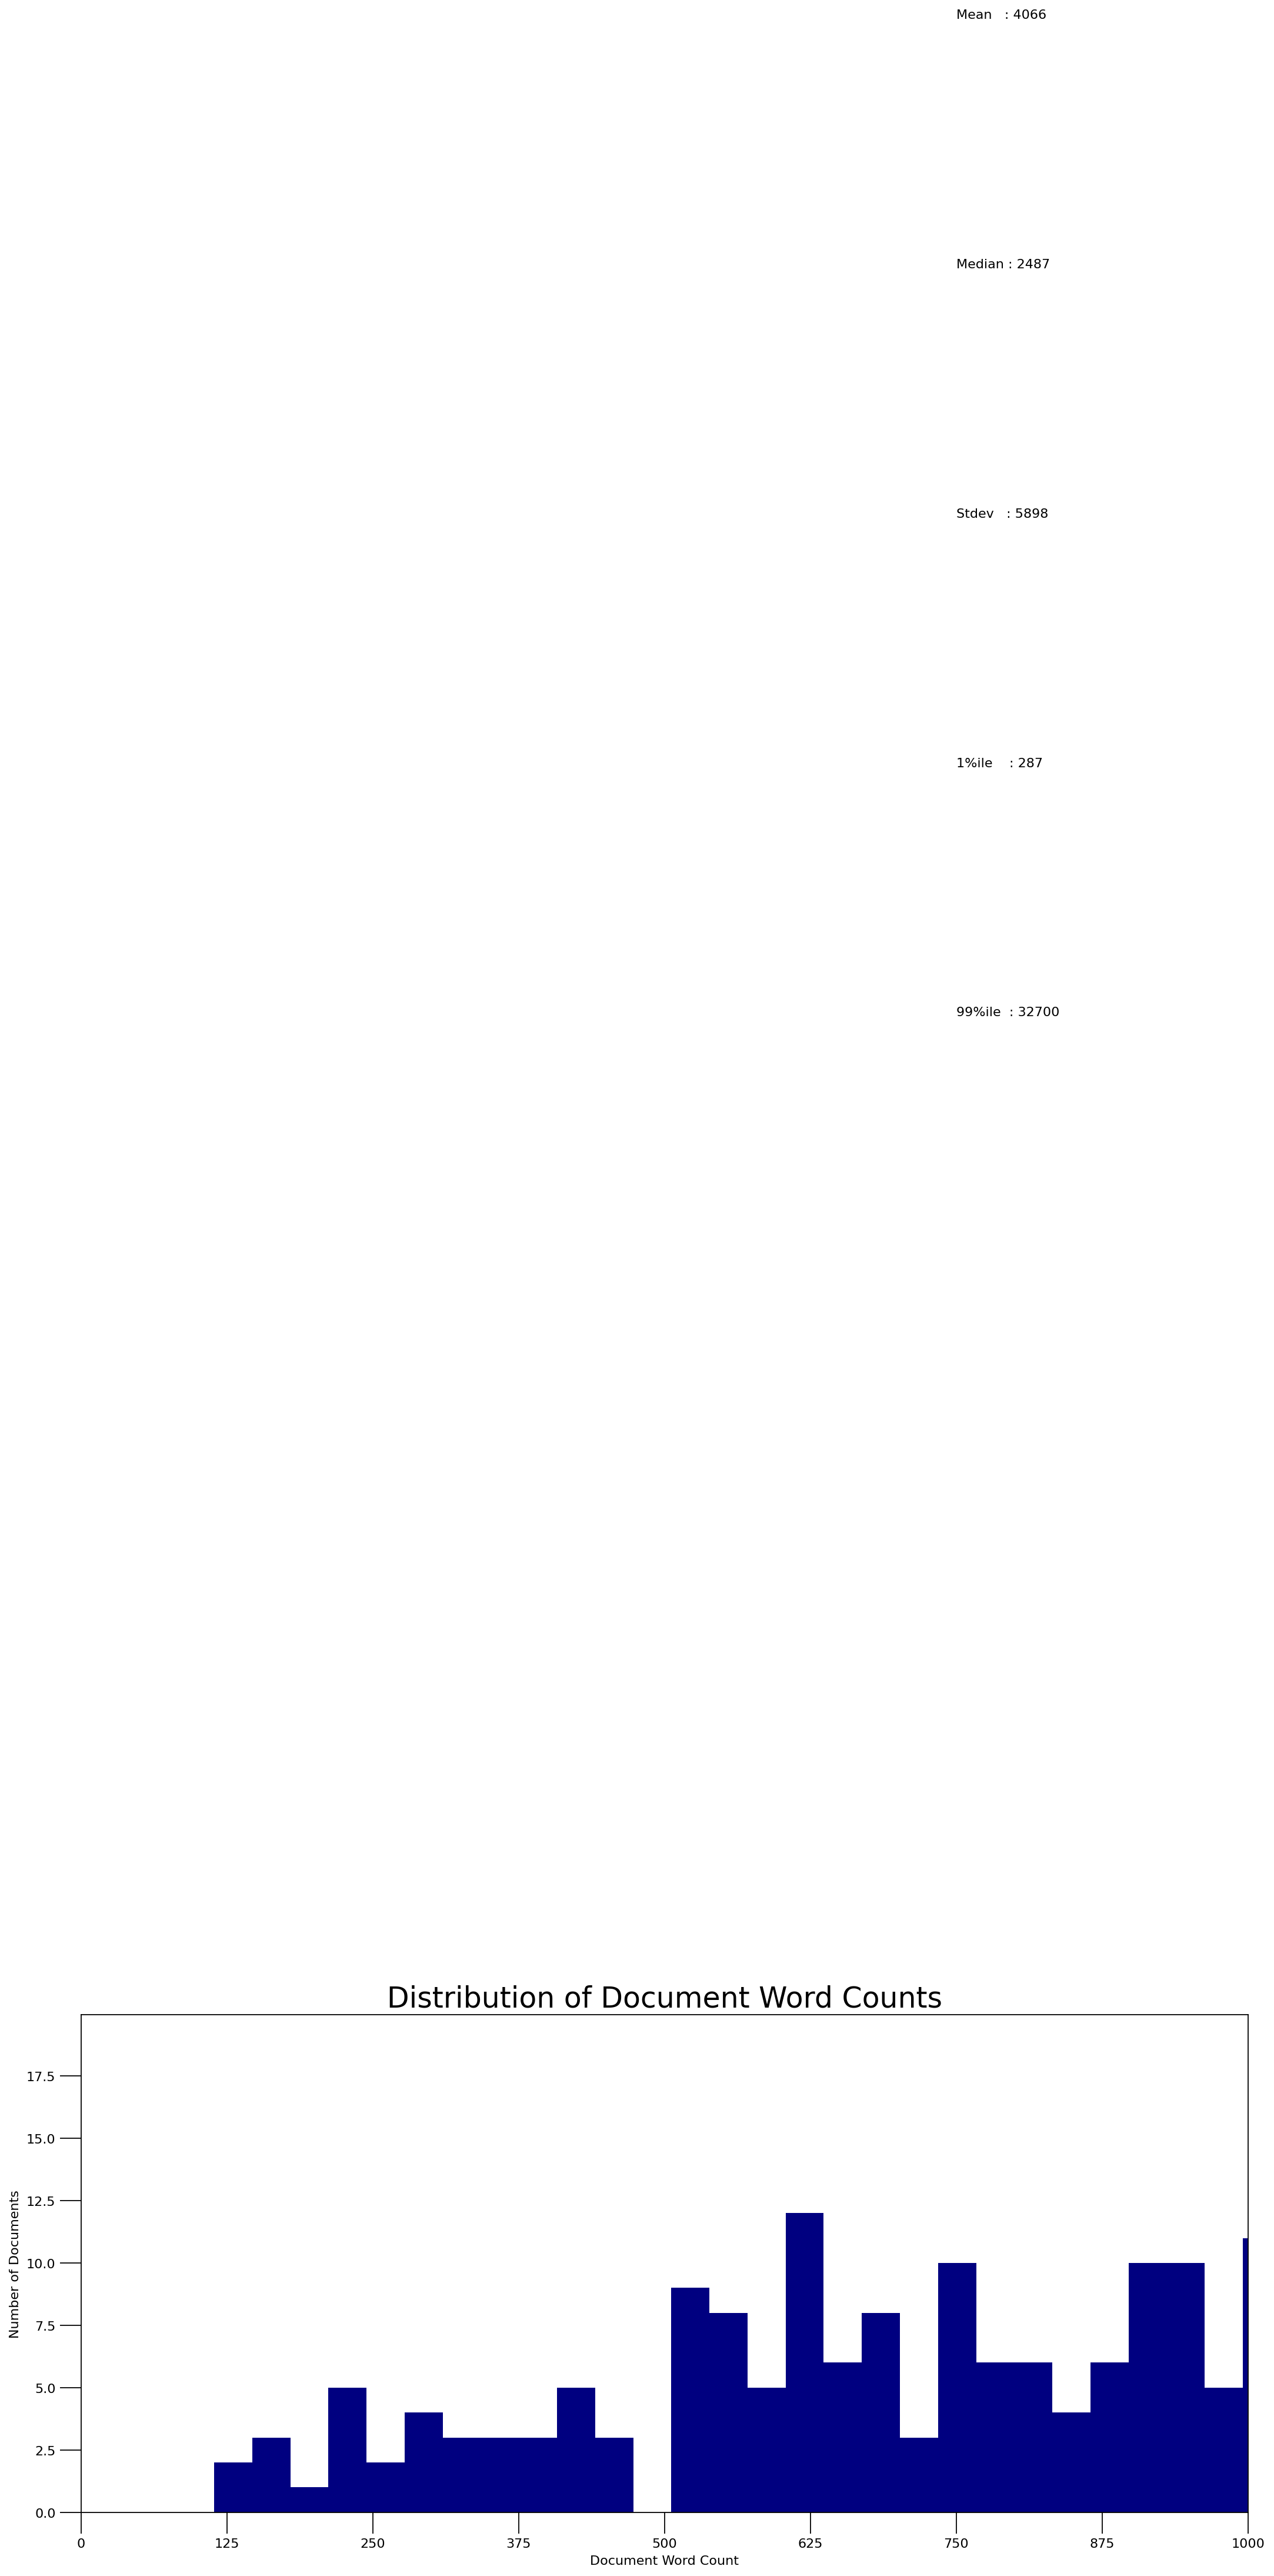

In [54]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

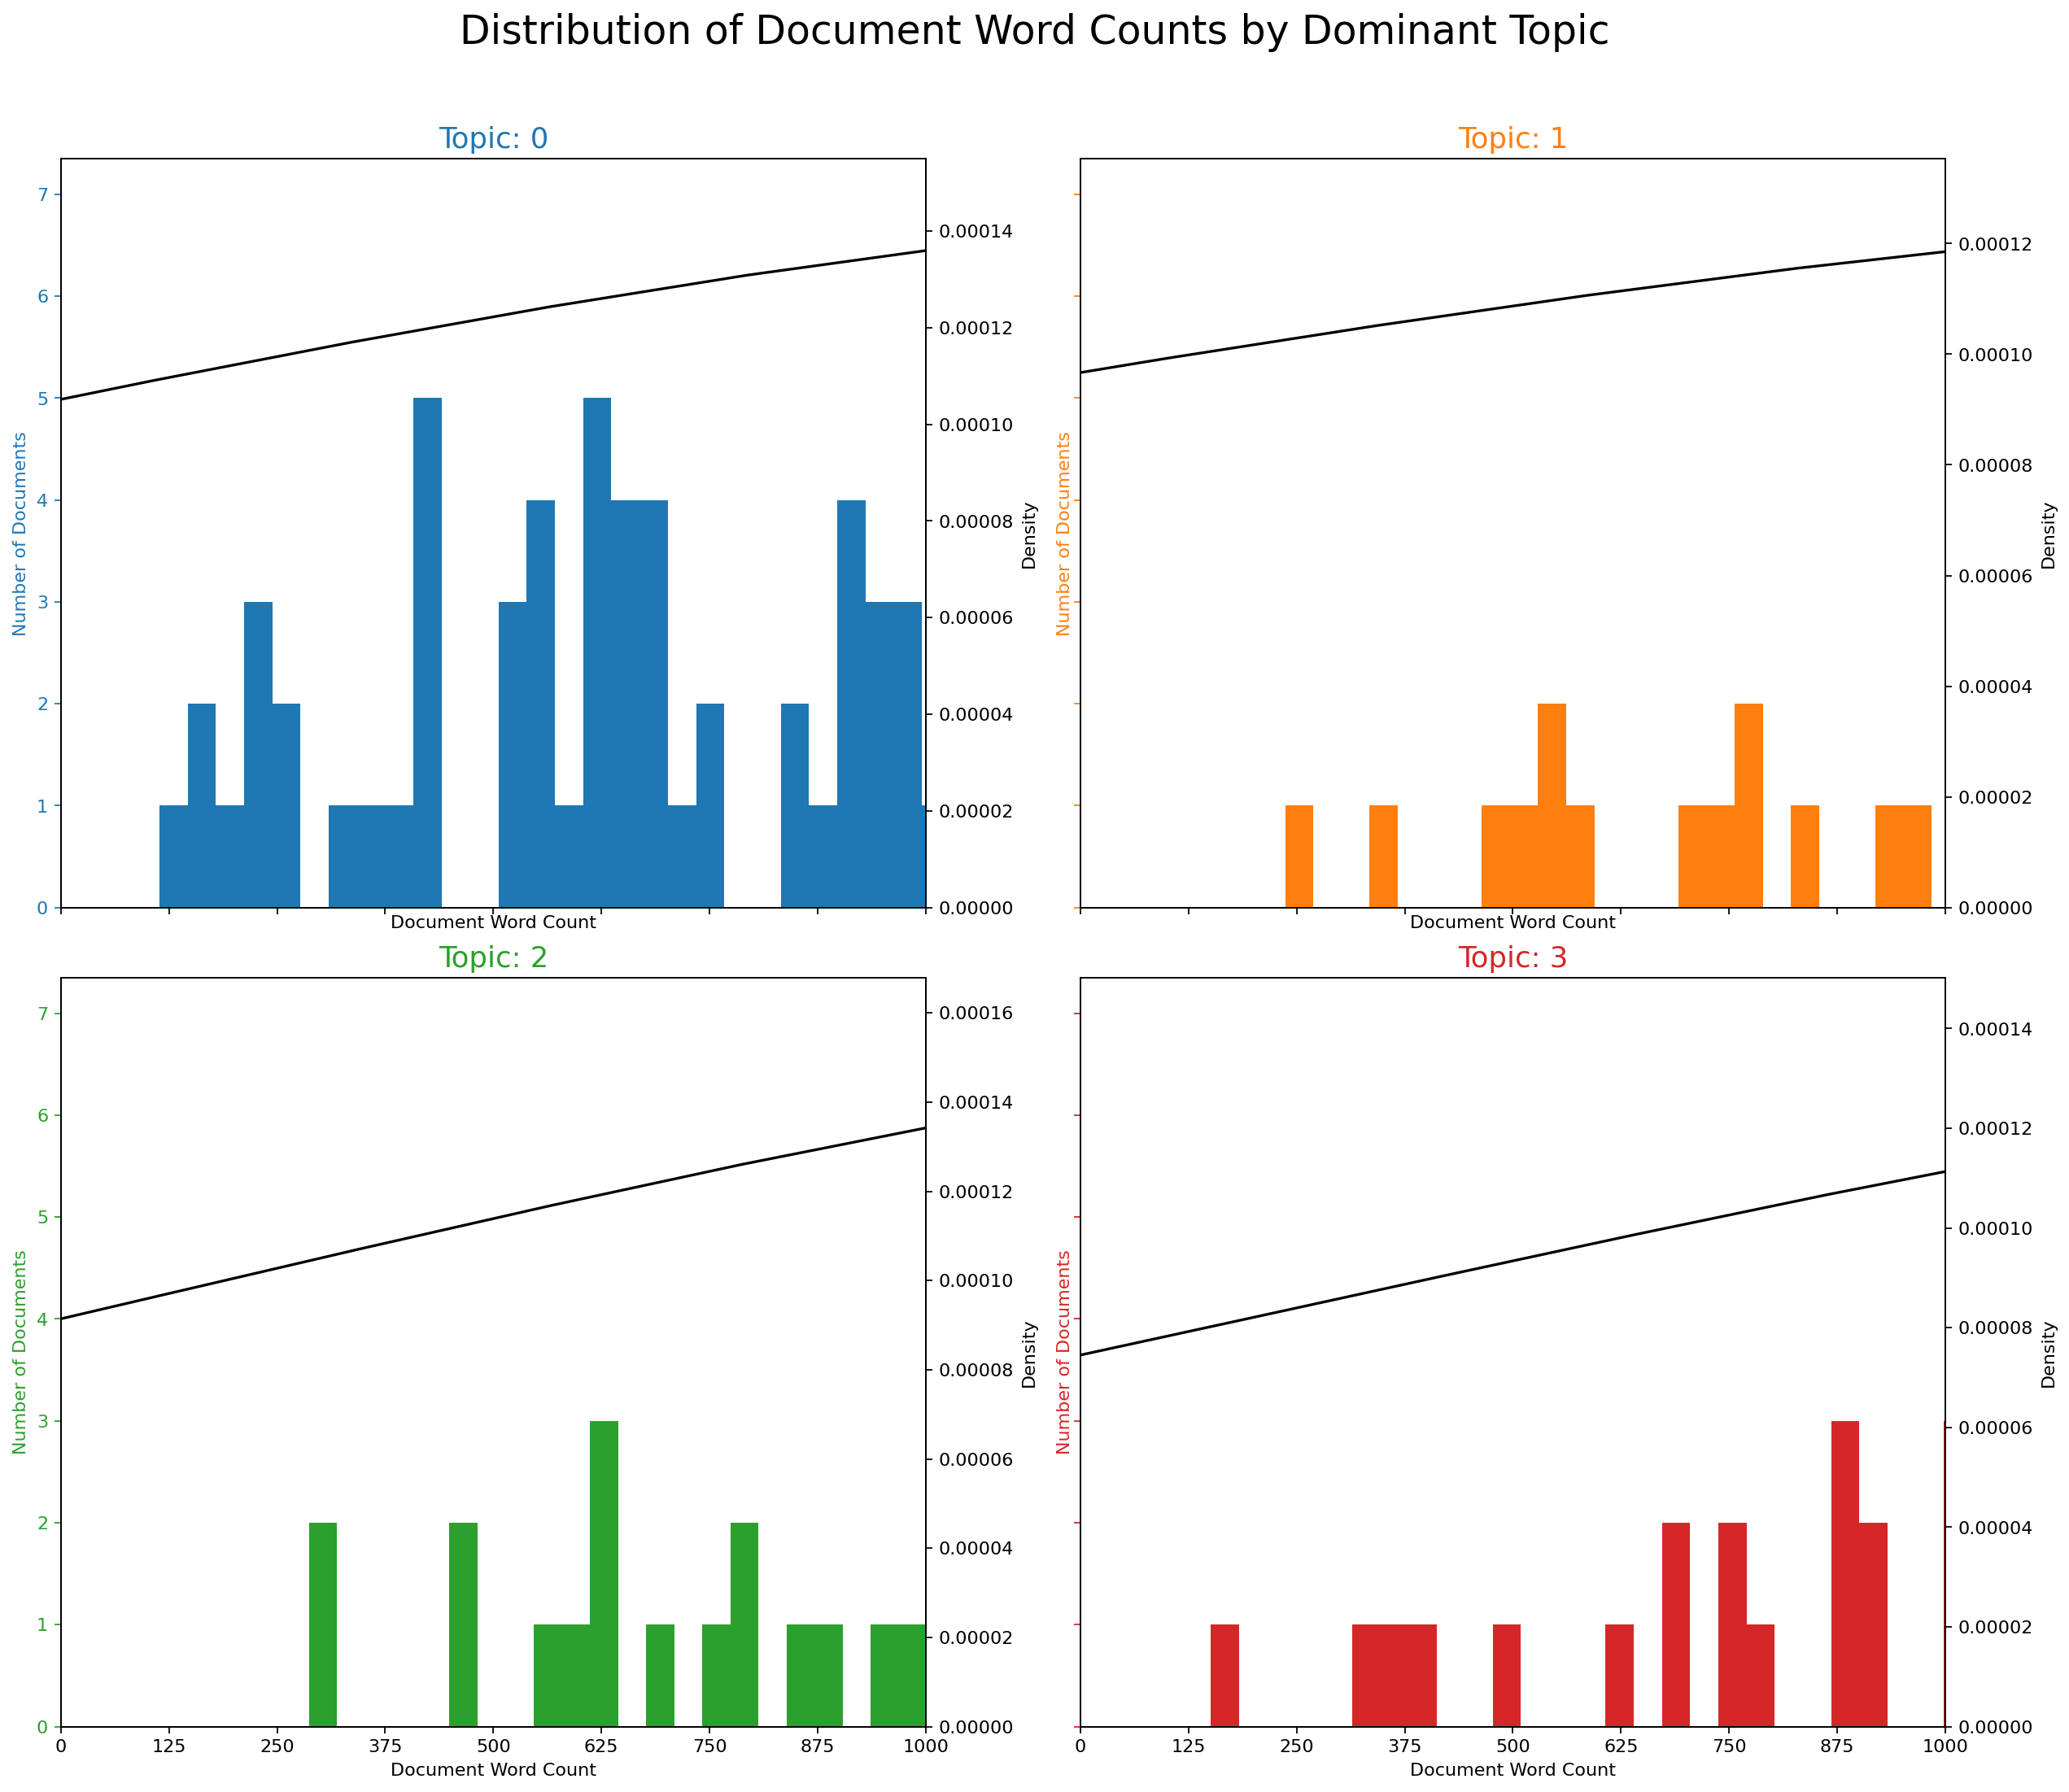

In [55]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

In [56]:
# We estimated our topics to be described around the following themes
topic_names = [
  'value employees',
  'strong governance', 
  'company transformation',
  'ethical investments',
  'sustainable finance'
]

# serialize topic names
json_data = json.dumps(topic_names, indent=2)
f = open("/tmp/topics.json", "w")
f.write(json_data)
f.close()

In [57]:
# 1. Wordcloud of Top N words in each topic
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stpwrd,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)
topics
# fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

# for i, ax in enumerate(axes.flatten()):
#     fig.add_subplot(ax)
#     topic_words = dict(topics[i][1])
#     cloud.generate_from_frequencies(topic_words, max_font_size=300)
#     plt.gca().imshow(cloud)
#     plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
#     plt.gca().axis('off')


# plt.subplots_adjust(wspace=0, hspace=0)
# plt.axis('off')
# plt.margins(x=0, y=0)
# plt.tight_layout()
# plt.show()

[(0,
  [('emission', 0.010676424),
   ('community', 0.0064145206),
   ('energy', 0.0061754077),
   ('safety', 0.0061275),
   ('water', 0.0061060037),
   ('sustainability', 0.0054223407),
   ('performance', 0.005135856),
   ('management', 0.004853351),
   ('business', 0.0048333607),
   ('operation', 0.0046843593)]),
 (1,
  [('energy', 0.008538053),
   ('emission', 0.007116341),
   ('management', 0.0068449937),
   ('community', 0.0068187774),
   ('water', 0.006486768),
   ('safety', 0.005829282),
   ('performance', 0.00521399),
   ('environmental', 0.00512737),
   ('gas', 0.0049157315),
   ('sustainability', 0.0045675915)]),
 (2,
  [('community', 0.0075256284),
   ('employee', 0.0067965873),
   ('management', 0.005695652),
   ('safety', 0.005588877),
   ('energy', 0.005468576),
   ('business', 0.004996198),
   ('sustainability', 0.0049660727),
   ('risk', 0.004478565),
   ('performance', 0.004150704),
   ('health', 0.0040580877)]),
 (3,
  [('emission', 0.006711662),
   ('energy', 0.00670

In [58]:
import pandas as pd
import pickle

# function that will take name of the company as input and will return Dominant topics and Text
def Company_data(name):
#     load pickle file and allocate into variable df_
    df_ = pd.read_pickle('data.pkl')
#     Search for given comapny and allocate data into new_df
    new_df = df_.loc[df_['Company'].isin([name])]
    return new_df[['Dominant_Topic', 'Text']]

In [60]:
company_name = 'Northland Power'

Company_data(company_name)

,Dominant_Topic,Text
1372,sustainable finance,The Power of Connection Sustainability Report 2020 About this report Northland Power Inc (North...
1373,strong governance,8 Northland Power Inc The Power of Connection Northland at a glance Our company Northland Power...
1374,sustainable finance,Our Planet Priority focus ‚ Greenhouse gas emissions ‚ Waste management ‚ Water management ‚ Bi...
1375,ethical investments,Sustainability Report 2020 Northland Power Inc 11 Evolution of Northland‚ green infrastructure ...
1376,ethical investments,Sustainability Report 2020 Northland Power Inc 13 Risks Increased variability of results Climat...
1377,strong governance,"Our renewable facilities help avoid 132 million tonnes of C02e Equivalent to taking 287,000 car..."
1378,sustainable finance,Sustainability Report 2020 Northland Power Inc 15 Commitment to renewable energy infrastructure ...
1379,ethical investments,16 Northland Power Inc The Power of Connection Managing our planet‚ shared resources Conscious ...
1380,sustainable finance,Sustainability Report 2020 Northland Power Inc 17 In our operations Our environmental management...
1381,value employees,Our People Priority focus ‚ Workforce health & safety ‚ Employee engagement and development ‚ D...
